# Post-processing

In [1]:
%matplotlib inline

We'll load the ground truths, but just for visualisation purposes.

In [2]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'r': int(coords[1] + .5),
                'c': int(coords[0] + .5),
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

r    c
sequence frame satellite          
1        1     1          237  502
               2          222  490
               3          129  141
         2     1          214  530
               2          199  518

Now we load the out-of-fold predictions, which were produced in the [previous notebook](Solution.ipynb).

In [3]:
with open('oof.json') as f:
    oof = json.load(f)
    
oof = pd.DataFrame([
    {
        'sequence': frame['sequence_id'],
        'frame': frame['frame'],
        'r': y + .5,
        'c': x + .5
    }
    for frame in oof
    for x, y in frame['object_coords']
])
oof = oof.set_index(['sequence', 'frame'])
oof.head()

r      c
sequence frame              
1        1      129.0  140.0
         1      221.0  489.0
         1      237.0  501.0
         2      107.0  167.0
         2      198.0  517.0

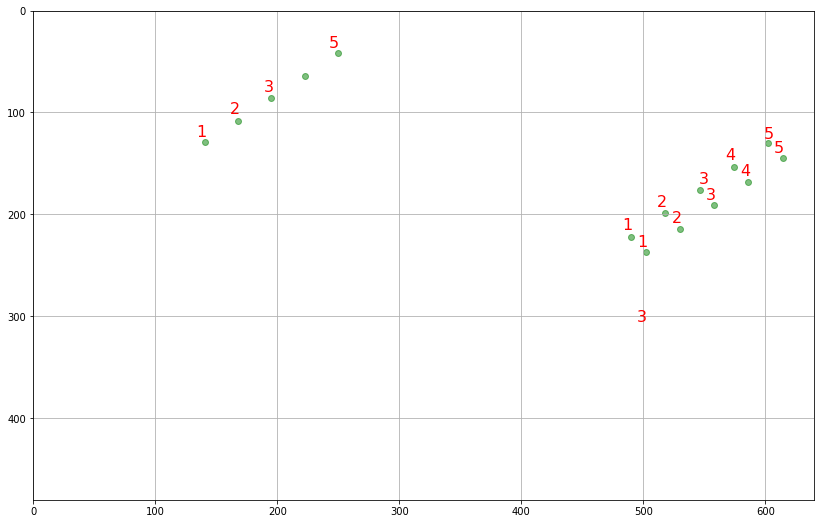

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 9))

sequence = 1

ax.set_xlim(0, 640)
ax.set_ylim(480, 0)
ax.grid()

try:
    for frame, (r, c) in oof.loc[sequence].iterrows():
        ax.text(c - 6, r - 6, frame, color='red', fontsize=16)
except KeyError:
    pass
  
try:
    for (frame, _), (r, c) in sats.loc[sequence].iterrows():
        ax.scatter(c, r, color='green', alpha=.5)
except KeyError:
    pass

In [5]:
from scipy import stats

class Trajectory:
    
    def __init__(self, frames, r, c):
        self.r_linreg = stats.linregress(x=frames, y=r)
        self.c_linreg = stats.linregress(x=frames, y=c)
        
    @property
    def good_fit(self):
        return abs(self.r_linreg.rvalue) > .999 and abs(self.c_linreg.rvalue) > .999
    
    def get_path(self):
        return [
            [
                self.r_linreg.slope * frame + self.r_linreg.intercept,
                self.c_linreg.slope * frame + self.c_linreg.intercept,
            ]
            for frame in range(1, 6)
        ]

Let's look at the average distance between positions of a single satellite.

In [6]:
counts = sats.groupby(['sequence']).size()
single = counts[counts.eq(5)]
sats.loc[single.index].groupby('sequence').apply(lambda g: g.diff()['r'].abs() + g.diff()['c'].abs()).agg(['mean', 'std', 'min', 'max'])

mean    45.710591
std      8.207040
min     12.000000
max     81.000000
dtype: float64

In [7]:
import itertools

def find_trajectory(frames):

    # We first consider all the trajectories that are formed with 3, 4, or 5 points from different
    # frame. We fit a line to every possible point combination. We stop if we find a "good" line.
    # We can then remove the involved points and call this function once again.
    for k in range(5, 2, -1):
        for frame_combo in itertools.combinations(range(5), k):
            for coord_combo in itertools.product(*[range(len(frames[f])) for f in frame_combo]):
                r = [frames[i][j][0] for i, j in zip(frame_combo, coord_combo)]
                c = [frames[i][j][1] for i, j in zip(frame_combo, coord_combo)]
                traj = Trajectory(frames=[f + 1 for f in frame_combo], r=r, c=c)
                if traj.good_fit:
                    return frame_combo, coord_combo, traj
        
    # Now we look at pairs of points in adjacent frames. We assume that two point from different
    # frames form a trajectory if their distance looks likely.
    for i1 in range(4):
        for i2 in range(i1 + 1, min(i1 + 3, 5)):
            for j1, j2 in itertools.product(range(len(frames[i1])), range(len(frames[i2]))):
                r1, c1 = frames[i1][j1]
                r2, c2 = frames[i2][j2]
                dist = abs(r1 - r2) + abs(c1 - c2)
                if 18 * (i2 - i1) <= dist <= 70 * (i2 - i1):
                    traj = Trajectory(frames=[i1 + 1, i2 + 1], r=[r1, r2], c=[c1, c2])
                    return (i1, i2), (j1, j2), traj
        
    return None

def expand_predictions(predictions):

    trajectories = []
              
    frames = [[] for _ in range(5)]
    for frame, (r, c) in predictions.iterrows():
        frames[frame - 1].append([r, c])

    while frames:

        result = find_trajectory(frames)
        if result is None:
            break

        frame_combo, coord_combo, traj = result
        trajectories.append(traj)
        for i, j in zip(frame_combo, coord_combo):
            del frames[i][j]
            
    if not trajectories:
        return pd.DataFrame()
            
    expansion = pd.concat([
        pd.DataFrame(traj.get_path(), columns=['r', 'c'])
        for traj in trajectories
    ])
    expansion.index.name = 'frame'
    expansion.index += 1
    
    return expansion

predictions = oof.loc[sequence]
expansion = expand_predictions(predictions)

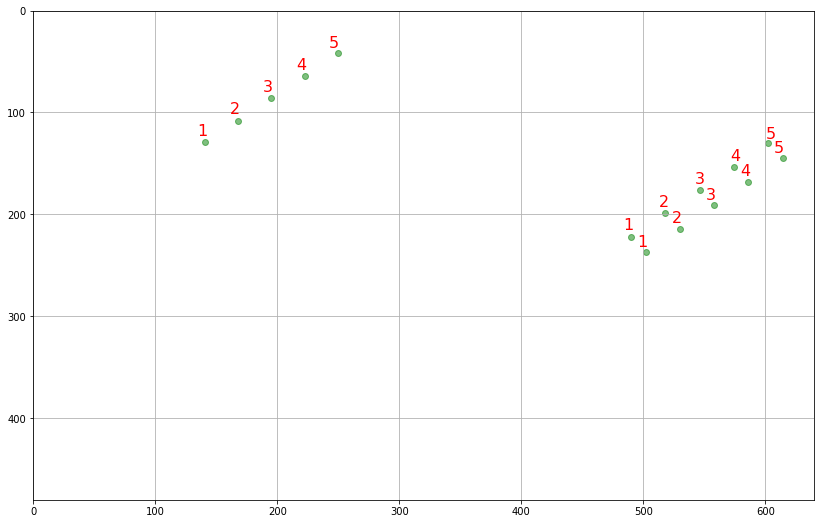

In [8]:
fig, ax = plt.subplots(figsize=(14, 9))

ax.set_xlim(0, 640)
ax.set_ylim(480, 0)
ax.grid()

for (frame, _), (r, c) in sats.loc[sequence].iterrows():
    ax.scatter(c, r, color='green', alpha=.5)
    
for frame, (r, c) in expansion.iterrows():
    ax.text(c - 6, r - 6, frame, color='red', fontsize=16)

## Out-of-fold predictions

In [9]:
import tqdm

oof_pp = pd.concat([
    expand_predictions(g.droplevel('sequence')).assign(sequence=sequence)
    for sequence, g in tqdm.tqdm(oof.groupby('sequence'), position=0)
])
oof_pp.index.name = 'frame'
oof_pp = oof_pp.reset_index().set_index(['sequence', 'frame'])
oof_pp.head()

100%|██████████| 995/995 [00:40<00:00, 24.60it/s]


r      c
sequence frame              
1        1      237.0  501.0
         2      214.0  529.0
         3      191.0  557.0
         4      168.0  585.0
         5      145.0  613.0

In [10]:
%run toolbox.py

<Figure size 432x288 with 0 Axes>

In [11]:
save_predictions(
    predictions=oof_pp.assign(is_sat=True).set_index(['r', 'c'], append=True)['is_sat'].sort_index(),
    path='oof_pp.json',
    n_sequences=1280
)

100%|██████████| 1280/1280 [00:02<00:00, 448.34it/s]


In [12]:
!python validation.py oof_pp.json data/spotGEO/train_anno.json

Score: 0.171077, (MSE: 24068.624683)


Score: 0.165742, (MSE: 23231.582095)


Score: 0.175603, (MSE: 24657.080911)

Score: 0.215491, (MSE: 19930.898756)

## Test predictions

In [13]:
with open('submission.json') as f:
    sub = json.load(f)

sub = pd.DataFrame([
    {
        'sequence': frame['sequence_id'],
        'frame': frame['frame'],
        'r': y + .5,
        'c': x + .5
    }
    for frame in sub
    for x, y in frame['object_coords']
])
sub = sub.set_index(['sequence', 'frame'])
sub.head()

r      c
sequence frame              
1        1      261.0  493.0
         2       32.0  487.0
         2      235.0  518.0
         2      248.0  335.0
         2      402.0   71.0

In [14]:
sub

r      c
sequence frame              
1        1      261.0  493.0
         2       32.0  487.0
         2      235.0  518.0
         2      248.0  335.0
         2      402.0   71.0
...               ...    ...
5120     1       87.0  369.0
         2       66.0  389.0
         3       46.0  408.0
         4       26.0  427.0
         5        5.0  446.0

[34480 rows x 2 columns]

In [15]:
sub_pp = pd.concat([
    expand_predictions(g.droplevel('sequence')).assign(sequence=sequence)
    for sequence, g in tqdm.tqdm(sub.groupby('sequence'), position=0)
])
sub_pp.index.name = 'frame'
sub_pp = sub_pp.reset_index().set_index(['sequence', 'frame'])
sub_pp.head()

100%|██████████| 4111/4111 [05:22<00:00, 12.75it/s] 


r      c
sequence frame              
1        1      261.0  493.0
         2      235.0  518.0
         3      209.0  543.0
         4      183.0  568.0
         5      157.0  593.0

In [18]:
save_predictions(
    predictions=sub_pp.assign(is_sat=True).set_index(['r', 'c'], append=True)['is_sat'].sort_index(),
    path='submission_pp.json',
    n_sequences=5120
)

100%|██████████| 5120/5120 [00:11<00:00, 435.84it/s]


In [17]:
import zipfile

with zipfile.ZipFile('submission_pp.zip', mode='w') as f:
    f.write('submission_pp.json')

That's all folks!